In [136]:
from torch_geometric.datasets import TUDataset
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchsummary import summary
import torch.nn.functional as F
from torch_geometric.transforms import TargetIndegree

import time
from torch_geometric.data import Data, DataLoader
import numpy.linalg as LA
import networkx as nx
from torch_geometric.utils import to_networkx


if torch.cuda.is_available() is False:
    raise Exception("GPU device not found, runtime environment should be set to GPU")
print(f"Using GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")

Using GPU device: GeForce RTX 2080 Ti


In [137]:
dataset=TUDataset('data', 'PROTEINS', transform=TargetIndegree(),use_node_attr=False) #saves normalized degree as edge_attr
print(f'Number of graphs: {len(dataset)}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Number of node features: {dataset.num_node_features}')

Number of graphs: 1113
Number of classes: 2
Number of node features: 3


In [204]:
num_nodes=[]
for i in range(len(dataset)):
    num_nodes.append(dataset[i].num_nodes)
np.mean(np.array(num_nodes))
num_edges=[]
for i in range(len(dataset)):
    num_nodes.append(dataset[i].num_nodes)
np.mean(np.array(num_nodes))

39.05750224618149

In [145]:
def k_fold_cross(dataset,i,test_size):
    min_idx = 100 * i
    max_idx = 100 * i+ test_size
    test_dataset = dataset[min_idx : max_idx]
    train_dataset = dataset[:min_idx]+dataset[max_idx:]
    train_loader=DataLoader(train_dataset,batch_size=100)
    test_loader=DataLoader(test_dataset,batch_size=test_size)
    return train_loader, test_loader


In [139]:
dataset =dataset.shuffle()
train_dataset = dataset[150:]
test_dataset = dataset[:150]
train_loader=DataLoader(train_dataset,batch_size=100)
test_loader=DataLoader(test_dataset,batch_size=150)
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 963
Number of test graphs: 150


In [140]:
from torch_geometric.nn import ChebConv
from torch_geometric.nn import BatchNorm
from torch_geometric.nn import global_mean_pool
class Cheb(nn.Module):
    def __init__(self, in_channel,hidden,K):
        super().__init__()
        self.conv1 = ChebConv(in_channel,hidden,K)
        self.bn1 = BatchNorm(hidden)
        self.dense1 = nn.Linear(hidden,2)
        self.relu = nn.ReLU()
        self.hidden=hidden
        self.history= None
        
    def forward(self,data):
        edge_index=data.edge_index
        h=data.x
        h = self.conv1(h, edge_index)
        h = self.bn1(h)
        h = self.relu(h)
        h = global_mean_pool(h, data.batch)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.dense1(h)
        
        return h

In [141]:
from torch_geometric.nn import ARMAConv
class ARMA(torch.nn.Module):
    def __init__(self,in_channel,hidden,K,N):
        super().__init__()
        self.conv1 = ARMAConv(in_channel,hidden,num_stacks=K, num_layers=N)
        self.bn1 = BatchNorm(hidden)
        self.dense1 = nn.Linear(hidden,2)
        self.relu = nn.ReLU()
        self.hidden=hidden
        self.history= None
        
    def forward(self,data):
        edge_index=data.edge_index
        h=data.x
        h = self.conv1(h, edge_index)
        h = self.bn1(h)
        h = self.relu(h)
        h = global_mean_pool(h, data.batch)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.dense1(h)
        
        return h

In [142]:
from torch_geometric.nn import SplineConv
class Spline(torch.nn.Module):
    def __init__(self,in_channel,hidden,kernel):
        super().__init__()
        self.conv1 = SplineConv(in_channel, hidden, dim=1, kernel_size=kernel)
        self.bn1 = BatchNorm(hidden)
        self.dense1 = torch.nn.Linear(hidden,2)

    def forward(self, data):
        h = F.relu(self.bn1(self.conv1(data.x, data.edge_index,data.edge_attr)))
        h = global_mean_pool(h, data.batch)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.dense1(h)
        return h



In [143]:
def training_loop(EPOCHS, MODEL, OPTIMIZER, device, train_loader, test_loader):
    #summary(MODEL)
    
    #if torch.cuda.is_available() is False:
        #raise Exception("GPU device not found, runtime environment should be set to GPU")
    #print(f"Using GPU device: {torch.cuda.get_device_name(device)}")
    
    
    criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
    history = {'train_loss': [], 'train_accuracy': [], 'test_loss': [],'test_accuracy': []
               ,'time':[]}

    for epoch in range(EPOCHS):
        start=time.time()
        
        temp_loss = 0
        correct=0
        graphs=0
        for step,data in enumerate(train_loader):
            data.to(device)
            OPTIMIZER.zero_grad()  # Clear gradients.
            y_out = MODEL(data) # Perform a single forward pass.
            loss = criterion(y_out, data.y)  # Compute the loss solely based on the training nodes.
            loss.backward()  # Derive gradients.
            OPTIMIZER.step()  # Update parameters based on gradients.
            
            temp_loss=temp_loss+loss.detach().item()
            pred = y_out.argmax(dim=1)  # Use the class with highest probability.
            correct =correct + int((pred == data.y).sum())
            graphs = graphs + data.num_graphs
            
        train_acc=correct / graphs
        train_loss=temp_loss/(step+1)
        
         
        temp_loss = 0
        correct=0
        graphs=0  
        for step,data in enumerate(test_loader):
            data.to(device)
            y_out =MODEL(data)
            loss = criterion(y_out,  data.y) 
            
            temp_loss =  temp_loss + loss.detach().item()
            pred = y_out.argmax(dim=1)  # Use the class with highest probability.
            correct =correct + int((pred == data.y).sum())
            graphs = graphs + data.num_graphs
        test_acc=correct / graphs
        test_loss=temp_loss/(step+1)
        
        end=time.time()
        
        print(f"Epoch: {epoch} | Train loss: {train_loss} | Train accuracy: {train_acc}  | Test loss: {test_loss} | Test accuracy: {test_acc}| Time: {end-start}")
        history['train_loss'].append(train_loss)
        history['train_accuracy'].append(train_acc)
        history['test_accuracy'].append(test_acc)
        history['test_loss'].append(test_loss)
        history['time'].append(end-start)
    return history

In [122]:
##TODOtrain
device = torch.cuda.current_device()
MODEL_Cheb=Cheb(3,30,10).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Cheb.parameters(), lr=0.003)   
EPOCHS = 50

Cheb_history = training_loop(EPOCHS, MODEL_Cheb, OPTIMIZER, device,train_loader,test_loader)

Epoch: 0 | Train loss: 0.667398339509964 | Train accuracy: 0.5939771547248183  | Test loss: 0.6417456269264221 | Test accuracy: 0.7| Time: 0.2729616165161133
Epoch: 1 | Train loss: 0.6356951713562011 | Train accuracy: 0.6583592938733126  | Test loss: 0.6155869960784912 | Test accuracy: 0.6866666666666666| Time: 0.17353129386901855
Epoch: 2 | Train loss: 0.6263999581336975 | Train accuracy: 0.6635514018691588  | Test loss: 0.5641006231307983 | Test accuracy: 0.7333333333333333| Time: 0.17470645904541016
Epoch: 3 | Train loss: 0.6249041438102723 | Train accuracy: 0.6728971962616822  | Test loss: 0.5631656646728516 | Test accuracy: 0.7466666666666667| Time: 0.17528772354125977
Epoch: 4 | Train loss: 0.627332454919815 | Train accuracy: 0.6780893042575286  | Test loss: 0.6028221249580383 | Test accuracy: 0.74| Time: 0.17973732948303223
Epoch: 5 | Train loss: 0.6319953501224518 | Train accuracy: 0.6697819314641744  | Test loss: 0.5619565844535828 | Test accuracy: 0.76| Time: 0.17480492591857

Epoch: 49 | Train loss: 0.5807980954647064 | Train accuracy: 0.7009345794392523  | Test loss: 0.5231199860572815 | Test accuracy: 0.7733333333333333| Time: 0.18710684776306152


In [146]:
Cheb_history=[]
MODEL={}
dataset=TUDataset('data', 'PROTEINS', transform=TargetIndegree(),use_node_attr=False)
for i in range(7):
    device = torch.cuda.current_device()
    MODEL['{}'.format(i)]=Cheb(3,30,10).to(device)
    OPTIMIZER =  torch.optim.Adam(MODEL['{}'.format(i)].parameters(), lr=0.003)   
    EPOCHS = 50
    train_loader,test_loader=k_fold_cross(dataset,i,150)
    
    Cheb_history.append(training_loop(EPOCHS, MODEL['{}'.format(i)], OPTIMIZER, device,train_loader,test_loader))
    print(i)

Epoch: 0 | Train loss: 0.8641078650951386 | Train accuracy: 0.5109034267912772  | Test loss: 0.39748096466064453 | Test accuracy: 0.94| Time: 0.5727667808532715
Epoch: 1 | Train loss: 0.729578074812889 | Train accuracy: 0.54932502596054  | Test loss: 0.4616624414920807 | Test accuracy: 0.94| Time: 0.22739601135253906
Epoch: 2 | Train loss: 0.7001768320798873 | Train accuracy: 0.573208722741433  | Test loss: 0.5796913504600525 | Test accuracy: 0.7466666666666667| Time: 0.22666263580322266
Epoch: 3 | Train loss: 0.6915817320346832 | Train accuracy: 0.5887850467289719  | Test loss: 0.6075260639190674 | Test accuracy: 0.7133333333333334| Time: 0.2304534912109375
Epoch: 4 | Train loss: 0.7008547008037567 | Train accuracy: 0.5420560747663551  | Test loss: 0.6682792901992798 | Test accuracy: 0.56| Time: 0.22895574569702148
Epoch: 5 | Train loss: 0.6794108033180237 | Train accuracy: 0.569055036344756  | Test loss: 0.6620506644248962 | Test accuracy: 0.6| Time: 0.2310013771057129
Epoch: 6 | Tra

Epoch: 49 | Train loss: 0.6756814777851105 | Train accuracy: 0.5669781931464174  | Test loss: 0.6371225714683533 | Test accuracy: 0.6533333333333333| Time: 0.22026324272155762
0
Epoch: 0 | Train loss: 0.8271000802516937 | Train accuracy: 0.3811007268951194  | Test loss: 0.5356530547142029 | Test accuracy: 0.8333333333333334| Time: 0.31276774406433105
Epoch: 1 | Train loss: 0.7120842218399048 | Train accuracy: 0.5451713395638629  | Test loss: 0.5816523432731628 | Test accuracy: 0.7866666666666666| Time: 0.18441271781921387
Epoch: 2 | Train loss: 0.7113779485225677 | Train accuracy: 0.5379023883696781  | Test loss: 0.6177564859390259 | Test accuracy: 0.7266666666666667| Time: 0.18426108360290527
Epoch: 3 | Train loss: 0.7111591219902038 | Train accuracy: 0.5368639667705088  | Test loss: 0.6627448797225952 | Test accuracy: 0.6133333333333333| Time: 0.18581628799438477
Epoch: 4 | Train loss: 0.7048169553279877 | Train accuracy: 0.5295950155763239  | Test loss: 0.6526427865028381 | Test acc

Epoch: 48 | Train loss: 0.6809830009937287 | Train accuracy: 0.5835929387331257  | Test loss: 0.6330147385597229 | Test accuracy: 0.66| Time: 0.17953014373779297
Epoch: 49 | Train loss: 0.6783371150493622 | Train accuracy: 0.5825545171339563  | Test loss: 0.6205750107765198 | Test accuracy: 0.7333333333333333| Time: 0.1794905662536621
1
Epoch: 0 | Train loss: 0.7941436648368836 | Train accuracy: 0.40498442367601245  | Test loss: 0.5415181517601013 | Test accuracy: 0.8933333333333333| Time: 0.24744343757629395
Epoch: 1 | Train loss: 0.7078793585300446 | Train accuracy: 0.54932502596054  | Test loss: 0.5415706634521484 | Test accuracy: 0.8933333333333333| Time: 0.1779038906097412
Epoch: 2 | Train loss: 0.7062061369419098 | Train accuracy: 0.5462097611630322  | Test loss: 0.5998246073722839 | Test accuracy: 0.7733333333333333| Time: 0.1799631118774414
Epoch: 3 | Train loss: 0.6975213527679444 | Train accuracy: 0.5212876427829699  | Test loss: 0.6158016920089722 | Test accuracy: 0.75333333

Epoch: 46 | Train loss: 0.6766089797019958 | Train accuracy: 0.5815160955347871  | Test loss: 0.6405307054519653 | Test accuracy: 0.72| Time: 0.21981358528137207
Epoch: 47 | Train loss: 0.6768370449543 | Train accuracy: 0.5680166147455867  | Test loss: 0.6169869303703308 | Test accuracy: 0.78| Time: 0.22006797790527344
Epoch: 48 | Train loss: 0.6790773391723632 | Train accuracy: 0.5565939771547248  | Test loss: 0.6442132592201233 | Test accuracy: 0.6733333333333333| Time: 0.22128629684448242
Epoch: 49 | Train loss: 0.6784847974777222 | Train accuracy: 0.5804776739356179  | Test loss: 0.6283360719680786 | Test accuracy: 0.7066666666666667| Time: 0.2247004508972168
2
Epoch: 0 | Train loss: 0.7959473133087158 | Train accuracy: 0.34890965732087226  | Test loss: 0.7175513505935669 | Test accuracy: 0.5133333333333333| Time: 0.31725382804870605
Epoch: 1 | Train loss: 0.7259511113166809 | Train accuracy: 0.4787123572170301  | Test loss: 0.6651542782783508 | Test accuracy: 0.6066666666666667| T

Epoch: 45 | Train loss: 0.6751587331295014 | Train accuracy: 0.5773624091381101  | Test loss: 0.6507694721221924 | Test accuracy: 0.64| Time: 0.20893168449401855
Epoch: 46 | Train loss: 0.6703274011611938 | Train accuracy: 0.5763239875389408  | Test loss: 0.6444821357727051 | Test accuracy: 0.6533333333333333| Time: 0.19493341445922852
Epoch: 47 | Train loss: 0.6739741325378418 | Train accuracy: 0.5773624091381101  | Test loss: 0.6581943035125732 | Test accuracy: 0.6666666666666666| Time: 0.1927473545074463
Epoch: 48 | Train loss: 0.6694395899772644 | Train accuracy: 0.5804776739356179  | Test loss: 0.6426060795783997 | Test accuracy: 0.64| Time: 0.19431042671203613
Epoch: 49 | Train loss: 0.6684765934944152 | Train accuracy: 0.5835929387331257  | Test loss: 0.6479200720787048 | Test accuracy: 0.6666666666666666| Time: 0.19574189186096191
3
Epoch: 0 | Train loss: 0.790710061788559 | Train accuracy: 0.3842159916926272  | Test loss: 0.5577027797698975 | Test accuracy: 0.8466666666666667|

Epoch: 43 | Train loss: 0.6748201370239257 | Train accuracy: 0.5846313603322949  | Test loss: 0.6500370502471924 | Test accuracy: 0.6866666666666666| Time: 0.17986392974853516
Epoch: 44 | Train loss: 0.6676343262195588 | Train accuracy: 0.5991692627206646  | Test loss: 0.6732763051986694 | Test accuracy: 0.5866666666666667| Time: 0.19593191146850586
Epoch: 45 | Train loss: 0.6694435119628906 | Train accuracy: 0.6064382139148494  | Test loss: 0.6884020566940308 | Test accuracy: 0.56| Time: 0.18350458145141602
Epoch: 46 | Train loss: 0.6704708337783813 | Train accuracy: 0.5919003115264797  | Test loss: 0.6816604733467102 | Test accuracy: 0.56| Time: 0.18834805488586426
Epoch: 47 | Train loss: 0.6685540020465851 | Train accuracy: 0.5939771547248183  | Test loss: 0.6747761368751526 | Test accuracy: 0.6133333333333333| Time: 0.17734789848327637
Epoch: 48 | Train loss: 0.6729054689407349 | Train accuracy: 0.5680166147455867  | Test loss: 0.6531751751899719 | Test accuracy: 0.6| Time: 0.17478

Epoch: 42 | Train loss: 0.6672222852706909 | Train accuracy: 0.5794392523364486  | Test loss: 0.6813929677009583 | Test accuracy: 0.6| Time: 0.22411775588989258
Epoch: 43 | Train loss: 0.671848464012146 | Train accuracy: 0.5960539979231568  | Test loss: 0.701633870601654 | Test accuracy: 0.5266666666666666| Time: 0.24594831466674805
Epoch: 44 | Train loss: 0.675173157453537 | Train accuracy: 0.5721703011422637  | Test loss: 0.6607821583747864 | Test accuracy: 0.5933333333333334| Time: 0.22179627418518066
Epoch: 45 | Train loss: 0.6623774707317353 | Train accuracy: 0.6033229491173416  | Test loss: 0.6750455498695374 | Test accuracy: 0.5533333333333333| Time: 0.2504763603210449
Epoch: 46 | Train loss: 0.6766403317451477 | Train accuracy: 0.5846313603322949  | Test loss: 0.7019805312156677 | Test accuracy: 0.5333333333333333| Time: 0.22505497932434082
Epoch: 47 | Train loss: 0.6634742438793182 | Train accuracy: 0.616822429906542  | Test loss: 0.6632317900657654 | Test accuracy: 0.62666666

Epoch: 40 | Train loss: 0.656618669629097 | Train accuracy: 0.6645898234683282  | Test loss: 0.736637532711029 | Test accuracy: 0.5133333333333333| Time: 0.1911635398864746
Epoch: 41 | Train loss: 0.6550762593746186 | Train accuracy: 0.6666666666666666  | Test loss: 0.7633329033851624 | Test accuracy: 0.4866666666666667| Time: 0.1772139072418213
Epoch: 42 | Train loss: 0.6539792865514755 | Train accuracy: 0.6500519210799585  | Test loss: 0.7501809000968933 | Test accuracy: 0.52| Time: 0.17579889297485352
Epoch: 43 | Train loss: 0.6522473901510238 | Train accuracy: 0.6583592938733126  | Test loss: 0.7475365996360779 | Test accuracy: 0.49333333333333335| Time: 0.17554497718811035
Epoch: 44 | Train loss: 0.6511348456144332 | Train accuracy: 0.6625129802699896  | Test loss: 0.7562195062637329 | Test accuracy: 0.48| Time: 0.17658090591430664
Epoch: 45 | Train loss: 0.6527101188898087 | Train accuracy: 0.6687435098650052  | Test loss: 0.7325161695480347 | Test accuracy: 0.49333333333333335| 

In [169]:
ARMA_history=[]
MODEL_A={}
dataset=TUDataset('data', 'PROTEINS', transform=TargetIndegree(),use_node_attr=False)
for i in range(7):
    device = torch.cuda.current_device()
    MODEL_A['{}'.format(i)]=ARMA(3,K=3,N=1, hidden=30).to(device)
    OPTIMIZER =  torch.optim.Adam(MODEL_A['{}'.format(i)].parameters(), lr=0.003)   
    EPOCHS = 50
    train_loader,test_loader=k_fold_cross(dataset,i,150)
    
    ARMA_history.append(training_loop(EPOCHS, MODEL_A['{}'.format(i)], OPTIMIZER, device,train_loader,test_loader))
    print(i)

Epoch: 0 | Train loss: 0.8203353643417358 | Train accuracy: 0.3312564901349948  | Test loss: 0.6483906507492065 | Test accuracy: 0.6133333333333333| Time: 0.3273489475250244
Epoch: 1 | Train loss: 0.7200744032859803 | Train accuracy: 0.4963655244029076  | Test loss: 0.6349834203720093 | Test accuracy: 0.6333333333333333| Time: 0.1896355152130127
Epoch: 2 | Train loss: 0.7189237296581268 | Train accuracy: 0.4953271028037383  | Test loss: 0.6368676424026489 | Test accuracy: 0.6733333333333333| Time: 0.2143251895904541
Epoch: 3 | Train loss: 0.7164177775382996 | Train accuracy: 0.4953271028037383  | Test loss: 0.6415172815322876 | Test accuracy: 0.6666666666666666| Time: 0.19933128356933594
Epoch: 4 | Train loss: 0.6947899222373962 | Train accuracy: 0.5275181723779855  | Test loss: 0.649226188659668 | Test accuracy: 0.6333333333333333| Time: 0.17325258255004883
Epoch: 5 | Train loss: 0.698041957616806 | Train accuracy: 0.5192107995846313  | Test loss: 0.6989279389381409 | Test accuracy: 0

Epoch: 48 | Train loss: 0.6765663623809814 | Train accuracy: 0.5742471443406023  | Test loss: 0.6522083282470703 | Test accuracy: 0.6733333333333333| Time: 0.15044522285461426
Epoch: 49 | Train loss: 0.6727875053882599 | Train accuracy: 0.6033229491173416  | Test loss: 0.6505398750305176 | Test accuracy: 0.7533333333333333| Time: 0.14824986457824707
0
Epoch: 0 | Train loss: 0.8373335987329483 | Train accuracy: 0.4797507788161994  | Test loss: 0.3928634822368622 | Test accuracy: 0.98| Time: 0.21547389030456543
Epoch: 1 | Train loss: 0.7270226776599884 | Train accuracy: 0.557632398753894  | Test loss: 0.47798287868499756 | Test accuracy: 0.9133333333333333| Time: 0.1491832733154297
Epoch: 2 | Train loss: 0.704861456155777 | Train accuracy: 0.557632398753894  | Test loss: 0.5686252117156982 | Test accuracy: 0.86| Time: 0.15256166458129883
Epoch: 3 | Train loss: 0.6897125601768493 | Train accuracy: 0.573208722741433  | Test loss: 0.5970562696456909 | Test accuracy: 0.82| Time: 0.1645259857

Epoch: 47 | Train loss: 0.6653456389904022 | Train accuracy: 0.6033229491173416  | Test loss: 0.6333910226821899 | Test accuracy: 0.7266666666666667| Time: 0.15451431274414062
Epoch: 48 | Train loss: 0.669794112443924 | Train accuracy: 0.5960539979231568  | Test loss: 0.6510749459266663 | Test accuracy: 0.6733333333333333| Time: 0.15126657485961914
Epoch: 49 | Train loss: 0.6677890539169311 | Train accuracy: 0.6105919003115264  | Test loss: 0.598920464515686 | Test accuracy: 0.78| Time: 0.14796018600463867
1
Epoch: 0 | Train loss: 0.829938542842865 | Train accuracy: 0.4423676012461059  | Test loss: 0.4620722532272339 | Test accuracy: 0.9333333333333333| Time: 0.2200908660888672
Epoch: 1 | Train loss: 0.7162385374307633 | Train accuracy: 0.5638629283489096  | Test loss: 0.5105621814727783 | Test accuracy: 0.88| Time: 0.15032601356506348
Epoch: 2 | Train loss: 0.7031269848346711 | Train accuracy: 0.5628245067497404  | Test loss: 0.5921767950057983 | Test accuracy: 0.8066666666666666| Tim

Epoch: 47 | Train loss: 0.6707720875740051 | Train accuracy: 0.6022845275181724  | Test loss: 0.6705817580223083 | Test accuracy: 0.6333333333333333| Time: 0.1533660888671875
Epoch: 48 | Train loss: 0.6695055961608887 | Train accuracy: 0.5939771547248183  | Test loss: 0.6505693197250366 | Test accuracy: 0.7133333333333334| Time: 0.15234851837158203
Epoch: 49 | Train loss: 0.6734507203102111 | Train accuracy: 0.5887850467289719  | Test loss: 0.6661125421524048 | Test accuracy: 0.6333333333333333| Time: 0.16792869567871094
2
Epoch: 0 | Train loss: 0.807006174325943 | Train accuracy: 0.3374870197300104  | Test loss: 0.6629891395568848 | Test accuracy: 0.6| Time: 0.23036432266235352
Epoch: 1 | Train loss: 0.7072503447532654 | Train accuracy: 0.5244029075804777  | Test loss: 0.6474387645721436 | Test accuracy: 0.66| Time: 0.14823603630065918
Epoch: 2 | Train loss: 0.6979165136814117 | Train accuracy: 0.5275181723779855  | Test loss: 0.6375081539154053 | Test accuracy: 0.64| Time: 0.15034747

Epoch: 46 | Train loss: 0.6857663273811341 | Train accuracy: 0.5555555555555556  | Test loss: 0.6592733860015869 | Test accuracy: 0.6533333333333333| Time: 0.15681672096252441
Epoch: 47 | Train loss: 0.6661841988563537 | Train accuracy: 0.5877466251298027  | Test loss: 0.6572928428649902 | Test accuracy: 0.68| Time: 0.16803693771362305
Epoch: 48 | Train loss: 0.6703691005706787 | Train accuracy: 0.6012461059190031  | Test loss: 0.6354097723960876 | Test accuracy: 0.74| Time: 0.15326786041259766
Epoch: 49 | Train loss: 0.6694322884082794 | Train accuracy: 0.6002076843198338  | Test loss: 0.6506532430648804 | Test accuracy: 0.6866666666666666| Time: 0.15291404724121094
3
Epoch: 0 | Train loss: 0.802957820892334 | Train accuracy: 0.31983385254413293  | Test loss: 0.7192122340202332 | Test accuracy: 0.44| Time: 0.21739888191223145
Epoch: 1 | Train loss: 0.7277823507785797 | Train accuracy: 0.4454828660436137  | Test loss: 0.6759839653968811 | Test accuracy: 0.6133333333333333| Time: 0.1533

Epoch: 45 | Train loss: 0.6670829236507416 | Train accuracy: 0.6116303219106958  | Test loss: 0.6808102130889893 | Test accuracy: 0.6066666666666667| Time: 0.15265679359436035
Epoch: 46 | Train loss: 0.675337016582489 | Train accuracy: 0.5939771547248183  | Test loss: 0.6957828998565674 | Test accuracy: 0.52| Time: 0.15291190147399902
Epoch: 47 | Train loss: 0.6671646773815155 | Train accuracy: 0.5867082035306335  | Test loss: 0.6717995405197144 | Test accuracy: 0.62| Time: 0.15526080131530762
Epoch: 48 | Train loss: 0.6584167540073395 | Train accuracy: 0.6095534787123572  | Test loss: 0.6637905836105347 | Test accuracy: 0.5933333333333334| Time: 0.1560823917388916
Epoch: 49 | Train loss: 0.6710994482040405 | Train accuracy: 0.6064382139148494  | Test loss: 0.6737579703330994 | Test accuracy: 0.5866666666666667| Time: 0.15743684768676758
4
Epoch: 0 | Train loss: 0.8484923005104065 | Train accuracy: 0.45898234683281414  | Test loss: 0.4716958701610565 | Test accuracy: 0.92| Time: 0.2247

Epoch: 44 | Train loss: 0.6658623516559601 | Train accuracy: 0.6064382139148494  | Test loss: 0.6429245471954346 | Test accuracy: 0.6266666666666667| Time: 0.1559758186340332
Epoch: 45 | Train loss: 0.6593689620494843 | Train accuracy: 0.6209761163032191  | Test loss: 0.6737257242202759 | Test accuracy: 0.5733333333333334| Time: 0.15788626670837402
Epoch: 46 | Train loss: 0.6572499811649323 | Train accuracy: 0.6105919003115264  | Test loss: 0.6647382378578186 | Test accuracy: 0.6266666666666667| Time: 0.15872430801391602
Epoch: 47 | Train loss: 0.6584721744060517 | Train accuracy: 0.6178608515057114  | Test loss: 0.6625062823295593 | Test accuracy: 0.6066666666666667| Time: 0.14986014366149902
Epoch: 48 | Train loss: 0.655650520324707 | Train accuracy: 0.616822429906542  | Test loss: 0.6969426274299622 | Test accuracy: 0.56| Time: 0.14970779418945312
Epoch: 49 | Train loss: 0.6574038624763489 | Train accuracy: 0.6282450674974039  | Test loss: 0.661241352558136 | Test accuracy: 0.606666

Epoch: 42 | Train loss: 0.6421220928430558 | Train accuracy: 0.6666666666666666  | Test loss: 0.7453542351722717 | Test accuracy: 0.44| Time: 0.15927410125732422
Epoch: 43 | Train loss: 0.6529286921024322 | Train accuracy: 0.6427829698857737  | Test loss: 0.7788670063018799 | Test accuracy: 0.47333333333333333| Time: 0.152313232421875
Epoch: 44 | Train loss: 0.6367611080408097 | Train accuracy: 0.6687435098650052  | Test loss: 0.8220376372337341 | Test accuracy: 0.3933333333333333| Time: 0.1507401466369629
Epoch: 45 | Train loss: 0.6446553081274032 | Train accuracy: 0.6614745586708204  | Test loss: 0.793268620967865 | Test accuracy: 0.4533333333333333| Time: 0.14946413040161133
Epoch: 46 | Train loss: 0.6463007777929306 | Train accuracy: 0.6645898234683282  | Test loss: 0.7572940587997437 | Test accuracy: 0.4666666666666667| Time: 0.1486220359802246
Epoch: 47 | Train loss: 0.6416283279657364 | Train accuracy: 0.6583592938733126  | Test loss: 0.7857927680015564 | Test accuracy: 0.466666

In [95]:
device = torch.cuda.current_device()
MODEL_ARMA=ARMA(3,K=3,N=1, hidden=30).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_ARMA.parameters(), lr=0.003)   
EPOCHS = 50

ARMA_history = training_loop(EPOCHS, MODEL_ARMA, OPTIMIZER, device,train_loader,test_loader)

Layer (type:depth-idx)                   Param #
├─ARMAConv: 1-1                          3,330
├─BatchNorm: 1-2                         --
|    └─BatchNorm1d: 2-1                  60
├─Linear: 1-3                            62
├─ReLU: 1-4                              --
Total params: 3,452
Trainable params: 3,452
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
Epoch: 0 | Train loss: 0.6728123486042022 | Train accuracy: 0.6033229491173416  | Test loss: 0.699432909488678 | Test accuracy: 0.5466666666666666| Time: 0.23945379257202148
Epoch: 1 | Train loss: 0.6683858096599579 | Train accuracy: 0.6033229491173416  | Test loss: 0.7012936472892761 | Test accuracy: 0.5466666666666666| Time: 0.2264714241027832
Epoch: 2 | Train loss: 0.6649268090724945 | Train accuracy: 0.6033229491173416  | Test loss: 0.7009919285774231 | Test accuracy: 0.5466666666666666| Time: 0.2253873348236084
Epoch: 3 | Train loss: 0.662159925699234 | Train accuracy: 0.6043613707165109  | Test loss: 0.704395

Epoch: 45 | Train loss: 0.6159342169761658 | Train accuracy: 0.7030114226375909  | Test loss: 0.6412826776504517 | Test accuracy: 0.6733333333333333| Time: 0.2379474639892578
Epoch: 46 | Train loss: 0.6155106365680695 | Train accuracy: 0.7019730010384216  | Test loss: 0.6408687233924866 | Test accuracy: 0.6733333333333333| Time: 0.21691632270812988
Epoch: 47 | Train loss: 0.6151064276695252 | Train accuracy: 0.7040498442367601  | Test loss: 0.6405404210090637 | Test accuracy: 0.6733333333333333| Time: 0.21941065788269043
Epoch: 48 | Train loss: 0.6147010028362274 | Train accuracy: 0.7030114226375909  | Test loss: 0.6401960253715515 | Test accuracy: 0.6733333333333333| Time: 0.22893214225769043
Epoch: 49 | Train loss: 0.6143380522727966 | Train accuracy: 0.7019730010384216  | Test loss: 0.6396669745445251 | Test accuracy: 0.6733333333333333| Time: 0.22367262840270996


In [170]:
Spline_history=[]
MODEL_S={}
dataset=TUDataset('data', 'PROTEINS', transform=TargetIndegree(),use_node_attr=False)
for i in range(7):
    device = torch.cuda.current_device()
    MODEL_S['{}'.format(i)]=Spline(3,hidden=30,kernel=10).to(device)
    OPTIMIZER =  torch.optim.Adam(MODEL_S['{}'.format(i)].parameters(), lr=0.003)   
    EPOCHS = 50
    train_loader,test_loader=k_fold_cross(dataset,i,150)
    
    Spline_history.append(training_loop(EPOCHS, MODEL_S['{}'.format(i)], OPTIMIZER, device,train_loader,test_loader))
    print(i)

Epoch: 0 | Train loss: 0.8430917203426361 | Train accuracy: 0.3811007268951194  | Test loss: 0.5304057598114014 | Test accuracy: 0.8466666666666667| Time: 0.285905122756958
Epoch: 1 | Train loss: 0.7285235166549683 | Train accuracy: 0.5264797507788161  | Test loss: 0.5790315866470337 | Test accuracy: 0.76| Time: 0.13900232315063477
Epoch: 2 | Train loss: 0.6967327177524567 | Train accuracy: 0.553478712357217  | Test loss: 0.635296642780304 | Test accuracy: 0.6533333333333333| Time: 0.1404261589050293
Epoch: 3 | Train loss: 0.6913044452667236 | Train accuracy: 0.569055036344756  | Test loss: 0.6739304661750793 | Test accuracy: 0.5533333333333333| Time: 0.1468677520751953
Epoch: 4 | Train loss: 0.6872900307178498 | Train accuracy: 0.5545171339563862  | Test loss: 0.6731535196304321 | Test accuracy: 0.58| Time: 0.13988089561462402
Epoch: 5 | Train loss: 0.6968879520893096 | Train accuracy: 0.5389408099688473  | Test loss: 0.6653419733047485 | Test accuracy: 0.5866666666666667| Time: 0.143

Epoch: 0 | Train loss: 0.8532484114170075 | Train accuracy: 0.48701973001038423  | Test loss: 0.41287699341773987 | Test accuracy: 0.9333333333333333| Time: 0.21140813827514648
Epoch: 1 | Train loss: 0.7229875206947327 | Train accuracy: 0.573208722741433  | Test loss: 0.46176329255104065 | Test accuracy: 0.9466666666666667| Time: 0.14320111274719238
Epoch: 2 | Train loss: 0.6947250604629517 | Train accuracy: 0.5898234683281413  | Test loss: 0.5651516914367676 | Test accuracy: 0.7533333333333333| Time: 0.14319896697998047
Epoch: 3 | Train loss: 0.6883827984333039 | Train accuracy: 0.5659397715472482  | Test loss: 0.5999261736869812 | Test accuracy: 0.72| Time: 0.14960670471191406
Epoch: 4 | Train loss: 0.6965751945972443 | Train accuracy: 0.5441329179646937  | Test loss: 0.6268455982208252 | Test accuracy: 0.6866666666666666| Time: 0.15254878997802734
Epoch: 5 | Train loss: 0.6975348591804504 | Train accuracy: 0.5295950155763239  | Test loss: 0.6234332323074341 | Test accuracy: 0.686666

Epoch: 48 | Train loss: 0.5674843221902848 | Train accuracy: 0.7476635514018691  | Test loss: 0.6555597186088562 | Test accuracy: 0.74| Time: 0.1462087631225586
Epoch: 49 | Train loss: 0.5621754288673401 | Train accuracy: 0.7403946002076843  | Test loss: 0.6860516667366028 | Test accuracy: 0.7066666666666667| Time: 0.14478087425231934
1
Epoch: 0 | Train loss: 0.8164994955062866 | Train accuracy: 0.38317757009345793  | Test loss: 0.5373762249946594 | Test accuracy: 0.8333333333333334| Time: 0.21035552024841309
Epoch: 1 | Train loss: 0.7235016644001007 | Train accuracy: 0.5015576323987538  | Test loss: 0.5464329719543457 | Test accuracy: 0.8333333333333334| Time: 0.14263534545898438
Epoch: 2 | Train loss: 0.6996864020824433 | Train accuracy: 0.5514018691588785  | Test loss: 0.5671000480651855 | Test accuracy: 0.8333333333333334| Time: 0.14211773872375488
Epoch: 3 | Train loss: 0.6858017027378083 | Train accuracy: 0.5638629283489096  | Test loss: 0.6050626039505005 | Test accuracy: 0.7933

Epoch: 47 | Train loss: 0.5559572100639343 | Train accuracy: 0.7663551401869159  | Test loss: 0.6913499236106873 | Test accuracy: 0.5866666666666667| Time: 0.18715691566467285
Epoch: 48 | Train loss: 0.5571422278881073 | Train accuracy: 0.7736240913811008  | Test loss: 0.6985915303230286 | Test accuracy: 0.6066666666666667| Time: 0.18001532554626465
Epoch: 49 | Train loss: 0.55803282558918 | Train accuracy: 0.7684319833852544  | Test loss: 0.6828022003173828 | Test accuracy: 0.62| Time: 0.1798102855682373
2
Epoch: 0 | Train loss: 0.8329315304756164 | Train accuracy: 0.36967808930425755  | Test loss: 0.5740787386894226 | Test accuracy: 0.7533333333333333| Time: 0.2654552459716797
Epoch: 1 | Train loss: 0.7290320754051208 | Train accuracy: 0.5316718587746625  | Test loss: 0.6067814826965332 | Test accuracy: 0.6733333333333333| Time: 0.1699209213256836
Epoch: 2 | Train loss: 0.7058208465576172 | Train accuracy: 0.5347871235721703  | Test loss: 0.6386194825172424 | Test accuracy: 0.66| Tim

Epoch: 46 | Train loss: 0.5520756602287292 | Train accuracy: 0.7673935617860852  | Test loss: 0.6651948094367981 | Test accuracy: 0.6133333333333333| Time: 0.18877768516540527
Epoch: 47 | Train loss: 0.5540330141782761 | Train accuracy: 0.7632398753894081  | Test loss: 0.689364492893219 | Test accuracy: 0.6133333333333333| Time: 0.1818397045135498
Epoch: 48 | Train loss: 0.535899218916893 | Train accuracy: 0.77466251298027  | Test loss: 0.6983626484870911 | Test accuracy: 0.6133333333333333| Time: 0.17942547798156738
Epoch: 49 | Train loss: 0.5391325712203979 | Train accuracy: 0.7798546209761164  | Test loss: 0.700709342956543 | Test accuracy: 0.6266666666666667| Time: 0.17752289772033691
3
Epoch: 0 | Train loss: 0.8950383752584458 | Train accuracy: 0.5295950155763239  | Test loss: 0.3001948893070221 | Test accuracy: 0.9933333333333333| Time: 0.26706504821777344
Epoch: 1 | Train loss: 0.7427291184663772 | Train accuracy: 0.5628245067497404  | Test loss: 0.43737852573394775 | Test accur

Epoch: 45 | Train loss: 0.5806814074516297 | Train accuracy: 0.7383177570093458  | Test loss: 0.7195000648498535 | Test accuracy: 0.5666666666666667| Time: 0.14118337631225586
Epoch: 46 | Train loss: 0.5882544934749603 | Train accuracy: 0.7185877466251298  | Test loss: 0.7219953536987305 | Test accuracy: 0.5933333333333334| Time: 0.14007091522216797
Epoch: 47 | Train loss: 0.5848520547151566 | Train accuracy: 0.7383177570093458  | Test loss: 0.739066481590271 | Test accuracy: 0.64| Time: 0.14098405838012695
Epoch: 48 | Train loss: 0.5763991147279739 | Train accuracy: 0.7497403946002077  | Test loss: 0.7533890008926392 | Test accuracy: 0.5666666666666667| Time: 0.13889598846435547
Epoch: 49 | Train loss: 0.5671504467725754 | Train accuracy: 0.7673935617860852  | Test loss: 0.7230504751205444 | Test accuracy: 0.62| Time: 0.1393744945526123
4
Epoch: 0 | Train loss: 0.8219742715358734 | Train accuracy: 0.3364485981308411  | Test loss: 0.6812049150466919 | Test accuracy: 0.5866666666666667|

Epoch: 45 | Train loss: 0.5675696343183517 | Train accuracy: 0.7538940809968847  | Test loss: 0.7459157705307007 | Test accuracy: 0.49333333333333335| Time: 0.18137836456298828
Epoch: 46 | Train loss: 0.5675213545560837 | Train accuracy: 0.7518172377985463  | Test loss: 0.7625779509544373 | Test accuracy: 0.4866666666666667| Time: 0.18015098571777344
Epoch: 47 | Train loss: 0.5608690738677978 | Train accuracy: 0.77466251298027  | Test loss: 0.7654871940612793 | Test accuracy: 0.5066666666666667| Time: 0.19225692749023438
Epoch: 48 | Train loss: 0.5681863635778427 | Train accuracy: 0.7403946002076843  | Test loss: 0.7479249835014343 | Test accuracy: 0.5133333333333333| Time: 0.19792985916137695
Epoch: 49 | Train loss: 0.5659387022256851 | Train accuracy: 0.7601246105919003  | Test loss: 0.7420300841331482 | Test accuracy: 0.56| Time: 0.17518949508666992
5
Epoch: 0 | Train loss: 0.8062205255031586 | Train accuracy: 0.5555555555555556  | Test loss: 0.8348122239112854 | Test accuracy: 0.46

Epoch: 43 | Train loss: 0.5900676786899567 | Train accuracy: 0.711318795430945  | Test loss: 0.7656518816947937 | Test accuracy: 0.4866666666666667| Time: 0.18490338325500488
Epoch: 44 | Train loss: 0.5857472717761993 | Train accuracy: 0.6967808930425753  | Test loss: 0.7935796976089478 | Test accuracy: 0.48| Time: 0.1564030647277832
Epoch: 45 | Train loss: 0.5625291466712952 | Train accuracy: 0.7393561786085151  | Test loss: 0.818444013595581 | Test accuracy: 0.4866666666666667| Time: 0.13924074172973633
Epoch: 46 | Train loss: 0.5689599692821503 | Train accuracy: 0.7237798546209762  | Test loss: 0.7881772518157959 | Test accuracy: 0.49333333333333335| Time: 0.13666772842407227
Epoch: 47 | Train loss: 0.5599868208169937 | Train accuracy: 0.7279335410176532  | Test loss: 0.7766669392585754 | Test accuracy: 0.4866666666666667| Time: 0.13983964920043945
Epoch: 48 | Train loss: 0.5749465733766556 | Train accuracy: 0.7185877466251298  | Test loss: 0.7374430894851685 | Test accuracy: 0.5466

In [35]:
device = torch.cuda.current_device()
MODEL_Spline=Spline(3,hidden=30,kernel=10).to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Spline.parameters(), lr=0.003)   
EPOCHS = 50

Spline_history = training_loop(EPOCHS, MODEL_Spline, OPTIMIZER, device,train_loader,test_loader)

Layer (type:depth-idx)                   Param #
├─SplineConv: 1-1                        1,020
├─BatchNorm: 1-2                         --
|    └─BatchNorm1d: 2-1                  60
├─Linear: 1-3                            62
Total params: 1,142
Trainable params: 1,142
Non-trainable params: 0
Epoch: 0 | Train loss: 0.6758150100708008 | Train accuracy: 0.5960539979231568  | Test loss: 0.6719807982444763 | Test accuracy: 0.5933333333333334| Time: 0.17067241668701172
Epoch: 1 | Train loss: 0.6702304720878601 | Train accuracy: 0.5960539979231568  | Test loss: 0.6666162014007568 | Test accuracy: 0.5933333333333334| Time: 0.1317141056060791
Epoch: 2 | Train loss: 0.6658624172210693 | Train accuracy: 0.5950155763239875  | Test loss: 0.6608961224555969 | Test accuracy: 0.5933333333333334| Time: 0.13033819198608398
Epoch: 3 | Train loss: 0.6599831283092499 | Train accuracy: 0.6012461059190031  | Test loss: 0.6532043218612671 | Test accuracy: 0.6133333333333333| Time: 0.13103294372558594
Epoch

Epoch: 45 | Train loss: 0.5526729226112366 | Train accuracy: 0.7144340602284528  | Test loss: 0.5595905184745789 | Test accuracy: 0.76| Time: 0.13164281845092773
Epoch: 46 | Train loss: 0.5522185057401657 | Train accuracy: 0.715472481827622  | Test loss: 0.5594809055328369 | Test accuracy: 0.76| Time: 0.13063716888427734
Epoch: 47 | Train loss: 0.5518671631813049 | Train accuracy: 0.715472481827622  | Test loss: 0.5592472553253174 | Test accuracy: 0.76| Time: 0.13109064102172852
Epoch: 48 | Train loss: 0.5514315247535706 | Train accuracy: 0.7165109034267912  | Test loss: 0.5590753555297852 | Test accuracy: 0.76| Time: 0.12949132919311523
Epoch: 49 | Train loss: 0.5510692596435547 | Train accuracy: 0.715472481827622  | Test loss: 0.5588437914848328 | Test accuracy: 0.76| Time: 0.13153386116027832
DONE


Text(0.5, 0, 'Epochs')

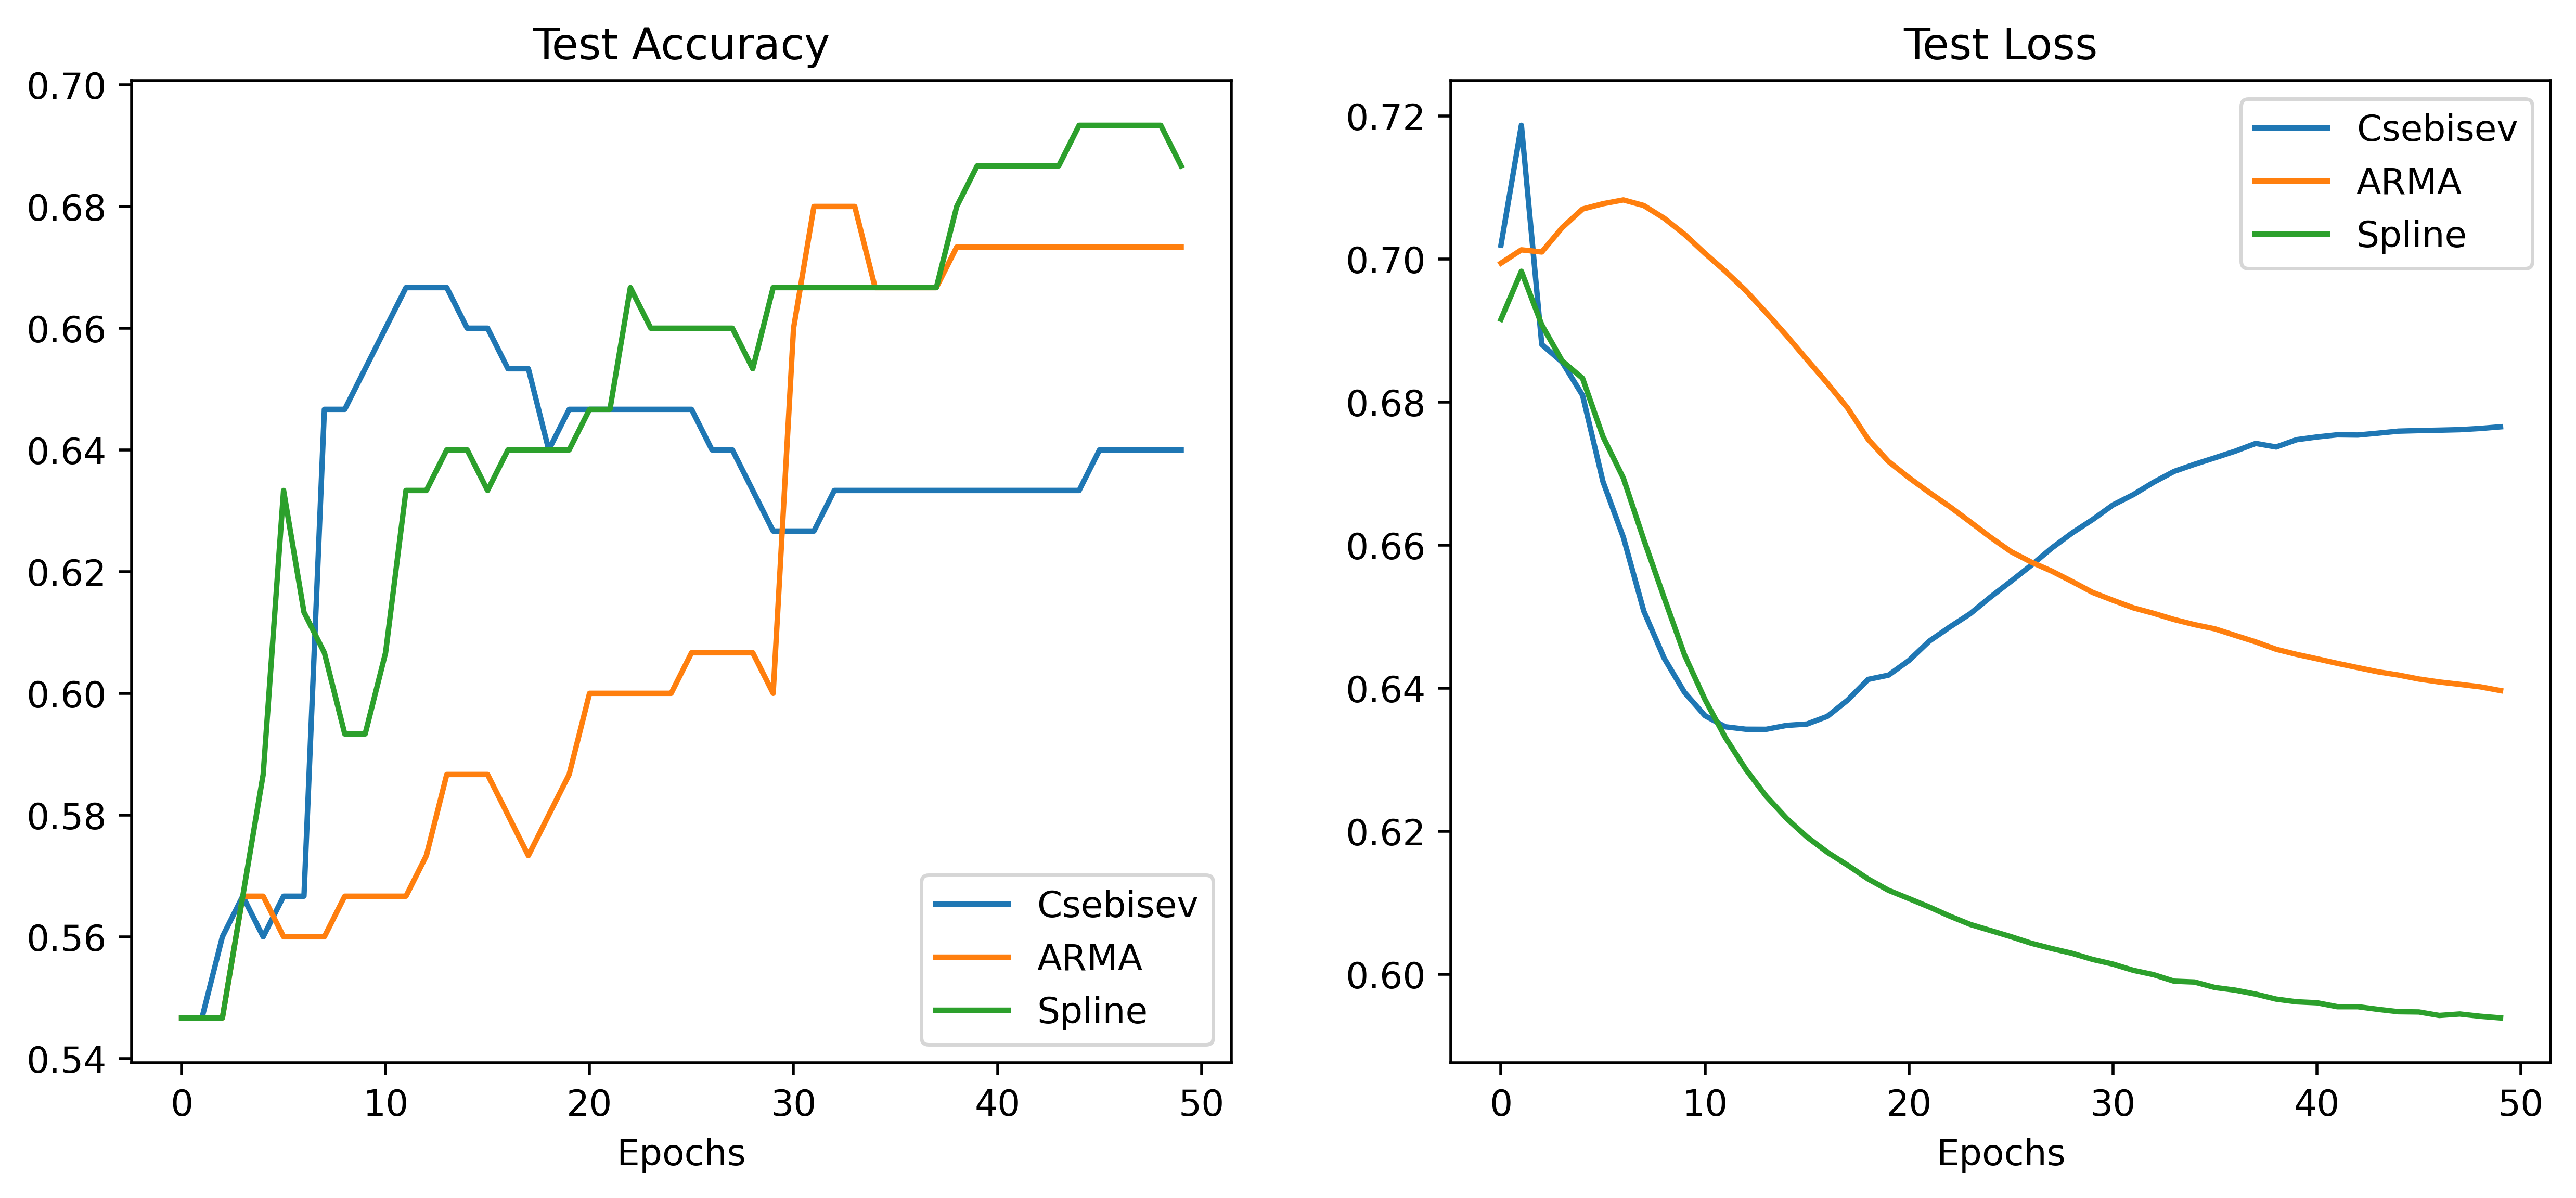

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5),dpi=500)
ax1.plot(np.arange(50),Cheb_history['test_accuracy'],label='Csebisev')
ax1.plot(np.arange(50),ARMA_history['test_accuracy'],label='ARMA')
ax1.plot(np.arange(50),Spline_history['test_accuracy'],label='Spline')
ax1.legend(loc=4)
ax1.set_title('Test Accuracy')
ax1.set_xlabel('Epochs')
ax2.plot(np.arange(50),Cheb_history['test_loss'],label='Csebisev')
ax2.plot(np.arange(50),ARMA_history['test_loss'],label='ARMA')
ax2.plot(np.arange(50),Spline_history['test_loss'],label='Spline')
ax2.legend(loc=1)
ax2.set_title('Test Loss')
ax2.set_xlabel('Epochs')

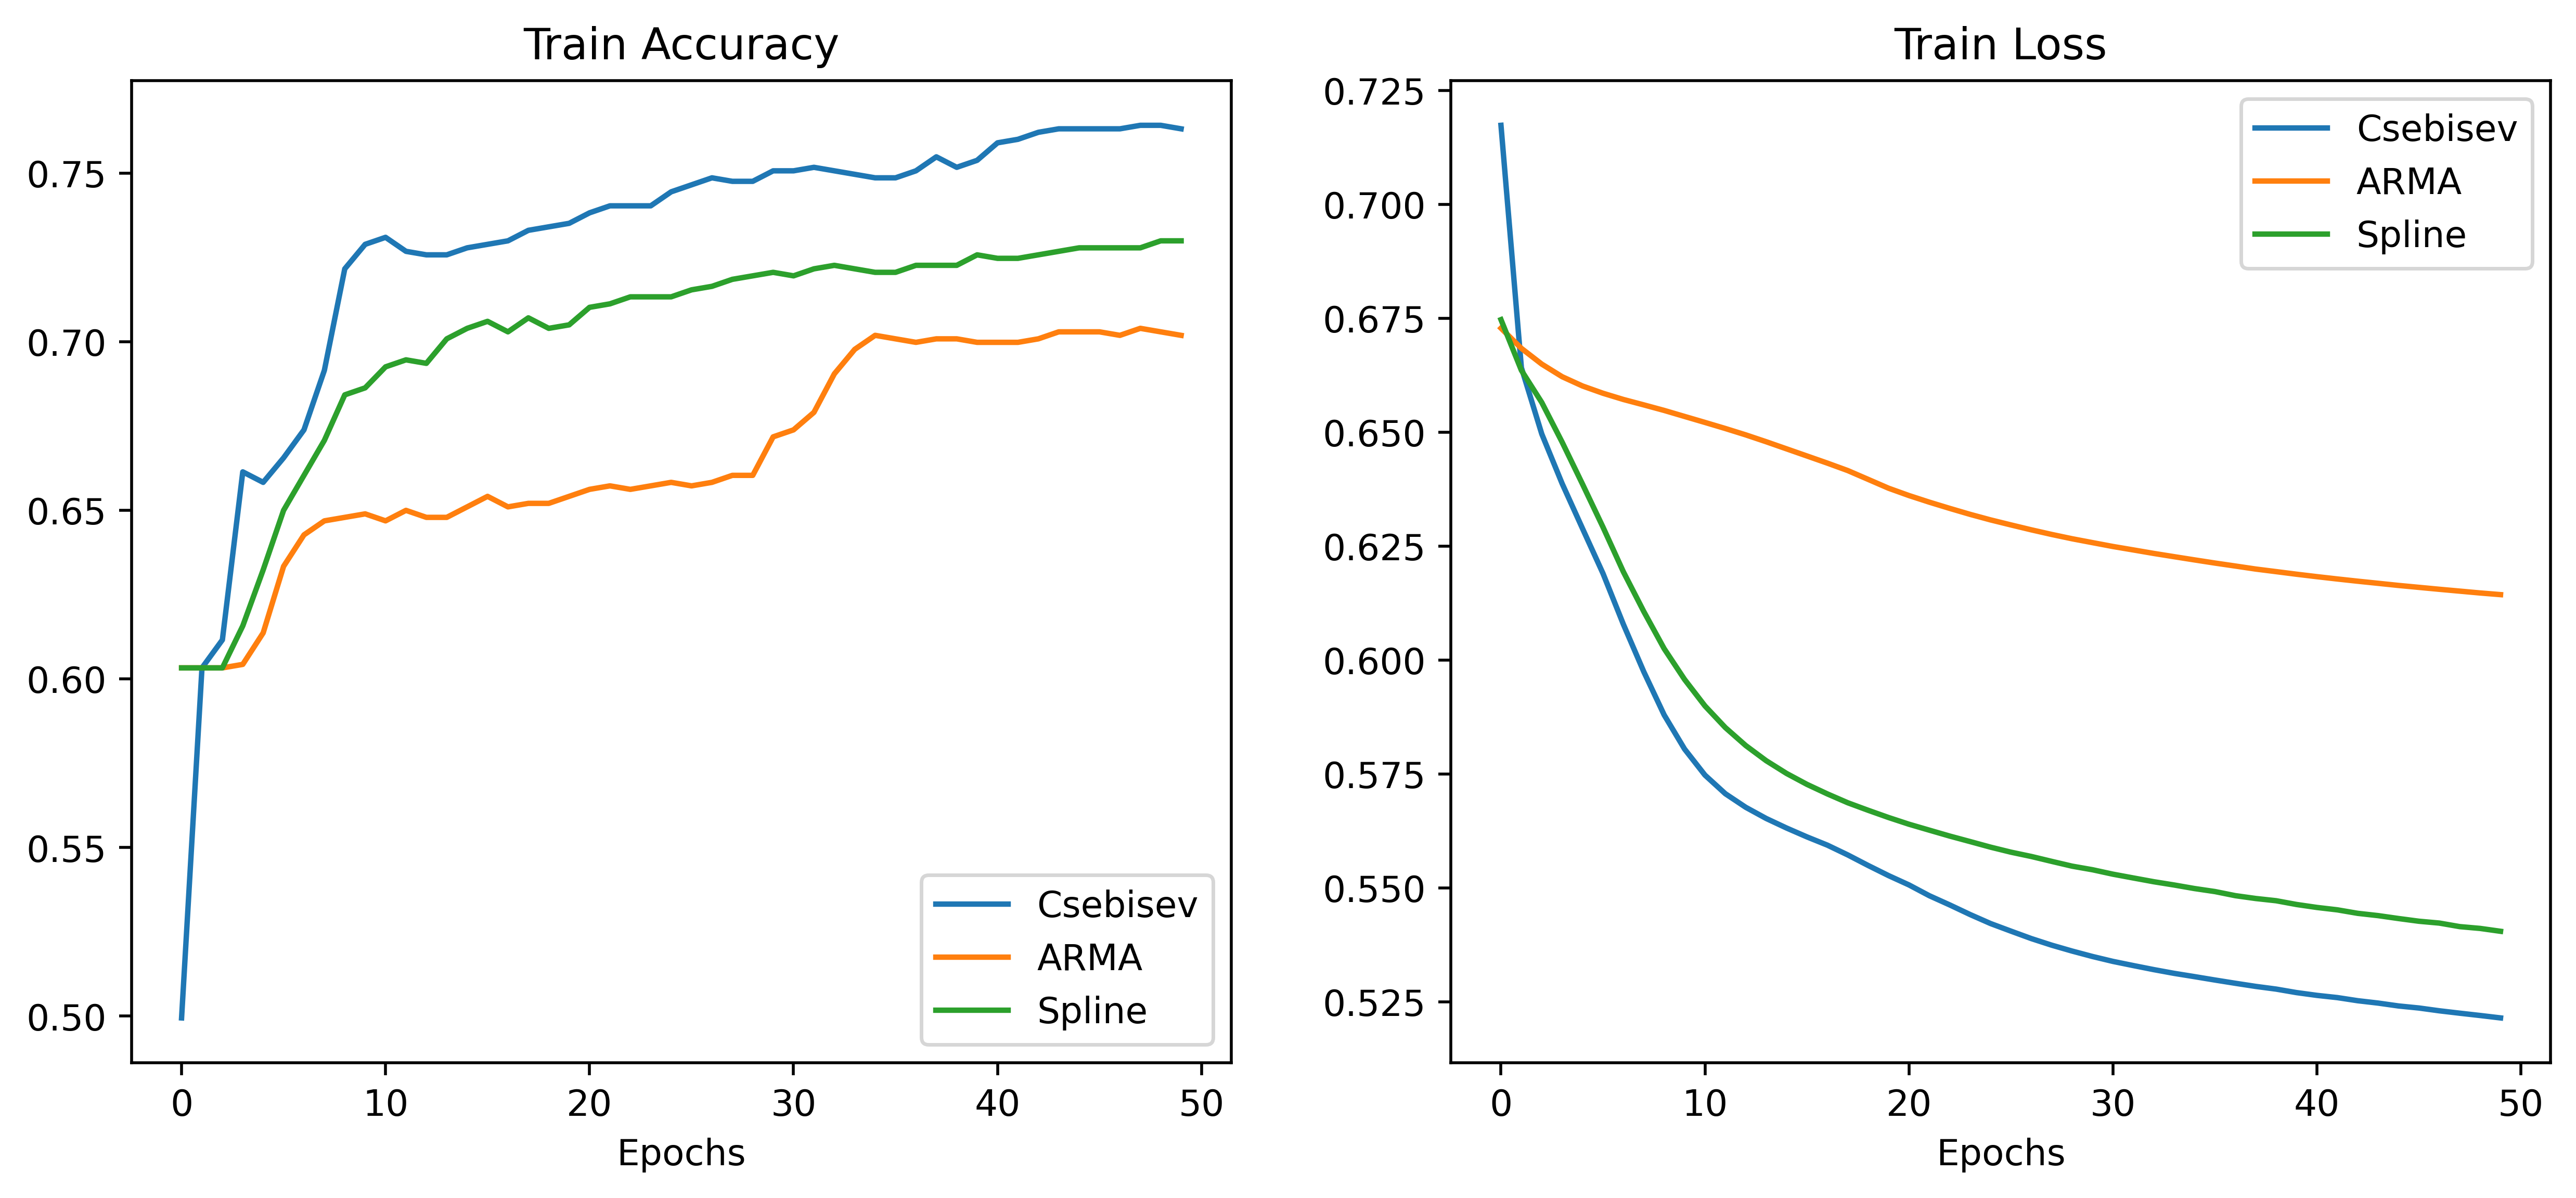

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,5),dpi=500)
ax1.set_title('Train Accuracy')
ax1.set_xlabel('Epochs')
ax1.plot(np.arange(50),Cheb_history['train_accuracy'],label='Csebisev')
ax1.plot(np.arange(50),ARMA_history['train_accuracy'],label='ARMA')
ax1.plot(np.arange(50),Spline_history['train_accuracy'],label='Spline')
ax1.legend(loc=4)
ax2.set_title('Train Loss')
ax2.set_xlabel('Epochs')
ax2.plot(np.arange(50),Cheb_history['train_loss'],label='Csebisev')
ax2.plot(np.arange(50),ARMA_history['train_loss'],label='ARMA')
ax2.plot(np.arange(50),Spline_history['train_loss'],label='Spline')
ax2.legend(loc=1)

In [16]:
from CayleyNet import CayleyConv
class Cayley(torch.nn.Module):
    def __init__(self,in_channel,hidden,degree):
        super().__init__()
        self.conv1 = CayleyConv(in_channel, hidden,5,jacobi_iterations=10)
        self.bn1 = BatchNorm(hidden)
        self.dense1 = torch.nn.Linear(hidden,2)

    def forward(self, data):
        h = F.relu(self.bn1(self.conv1(data.x, data.edge_index)))
        h = global_mean_pool(h, data.batch)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.dense1(h)
        return h


In [28]:
#device = torch.cuda.current_device()
MODEL_Cayley=Cayley(3,hidden=30,degree=5)#.to(device)
OPTIMIZER =  torch.optim.Adam(MODEL_Cayley.parameters(), lr=0.003)   
EPOCHS = 2

Cayley_history = training_loop(EPOCHS, MODEL_Cayley, OPTIMIZER, device,train_loader,test_loader)

Layer (type:depth-idx)                   Param #
├─CayleyConv: 1-1                        1,110
├─BatchNorm: 1-2                         --
|    └─BatchNorm1d: 2-1                  60
├─Linear: 1-3                            62
Total params: 1,232
Trainable params: 1,232
Non-trainable params: 0
Using GPU device: GeForce RTX 2080 Ti
0
1
2
3
4
5
6
7
8
9
Epoch: 0 | Train loss: 0.6792101383209228 | Train accuracy: 0.5804776739356179  | Test loss: 0.6754544377326965 | Test accuracy: 0.5933333333333334| Time: 75.73573160171509
0
1
2
3
4
5
6
7
8
9
Epoch: 1 | Train loss: 0.6744824469089508 | Train accuracy: 0.5960539979231568  | Test loss: 0.6739212274551392 | Test accuracy: 0.5933333333333334| Time: 76.11377096176147


In [180]:
#Cheb stats
acc=[max(Cheb_history[i]['test_accuracy']) for i in range(7)]
acc=np.array(acc)
acc
print(np.mean(acc))
print(np.var(acc,ddof=1))
loss=[max(Cheb_history[i]['test_loss']) for i in range(7)]
loss=np.array(loss)
print(np.mean(loss))
print(np.var(loss,ddof=1))
time=[(Cheb_history[i]['time']) for i in range(7)]
print(np.mean(np.array(time)))

0.7914285714285715
0.018706878306878307
0.7165611982345581
0.0036347984933430646
0.1972122757775443


In [181]:
#ARMA stats
acc=[max(ARMA_history[i]['test_accuracy']) for i in range(7)]
acc=np.array(acc)
acc
print(np.mean(acc))
print(np.var(acc,ddof=1))
loss=[max(ARMA_history[i]['test_loss']) for i in range(7)]
loss=np.array(loss)
print(np.mean(loss))
print(np.var(loss,ddof=1))
time=[(ARMA_history[i]['time']) for i in range(7)]
print(np.mean(np.array(time)))

0.7847619047619049
0.02873650793650794
0.7279682414872306
0.00525507594820105
0.1589214747292655


In [188]:
#Spline stats
acc=[max(Spline_history[i]['test_accuracy']) for i in range(7)]
acc=np.array(acc)
acc
print(np.mean(acc))
print(np.var(acc,ddof=1))
loss=[max(Spline_history[i]['test_loss']) for i in range(7)]
loss=np.array(loss)
print(np.mean(loss))
print(np.var(loss,ddof=1))
time=[(Spline_history[i]['time']) for i in range(7)]
print(np.mean(np.array(time)))

0.7942857142857144
0.02565079365079365
0.740130501134055
0.0035564502492357445
0.1573805754525321
